# Implement and train a LSTM for sentiment analysis

(General Hint on Lab 1/2: Trust whatever you see from the training and report it on PDF. IDMB is far from ideal as it's more like a real-world dataset)

## Step 0: set up the environment

In [1]:
import functools
import sys
import numpy as np
import pandas as pd
import random
import re
import matplotlib.pyplot as plt
import tqdm
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

nltk.download('stopwords')

torch.backends.cudnn.benchmark = True

import os
os.makedirs("resources", exist_ok=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Hyperparameters. Do not directly touch this to mess up settings.

If you want to initalize new hyperparameter sets, use "new_hparams = HyperParams()" and change corresponding fields.

In [2]:
class HyperParams:
    def __init__(self):
        # Constance hyperparameters. They have been tested and don't need to be tuned.
        self.PAD_INDEX = 0
        self.UNK_INDEX = 1
        self.PAD_TOKEN = '<pad>'
        self.UNK_TOKEN = '<unk>'
        self.STOP_WORDS = set(stopwords.words('english'))
        self.MAX_LENGTH = 256
        self.BATCH_SIZE = 96
        self.EMBEDDING_DIM = 1
        self.HIDDEN_DIM = 100
        self.OUTPUT_DIM = 2
        self.N_LAYERS = 1
        self.DROPOUT_RATE = 0.0
        self.LR = 0.01
        self.N_EPOCHS = 5
        self.WD = 0
        self.OPTIM = "sgd"
        self.BIDIRECTIONAL = False
        self.SEED = 5

## Lab 1(a) Implement your own data loader function.  
First, you need to read the data from the dataset file on the local disk. 
Then, split the dataset into three sets: train, validation and test by 7:1:2 ratio.
Finally return x_train, x_valid, x_test, y_train, y_valid, y_test where x represents reviews and y represent labels.  

In [3]:
IMDB = pd.read_csv('./IMDBDataset.csv')
print(f"The length of the dataset is {len(IMDB)}")
IMDB.head()

The length of the dataset is 50000


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
def load_imdb(base_csv:str = './IMDBDataset.csv'):
    """
    Load the IMDB dataset
    :param base_csv: the path of the dataset file.
    :return: train, validation and test set.
    """
    # Add your code here. 
    df = pd.read_csv(base_csv)
    x = df.review.values
    y = df.sentiment.values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=42)

    print(f'shape of train data is {x_train.shape}')
    print(f'shape of validation data is {x_val.shape}')
    print(f'shape of test data is {x_test.shape}')
    
    return x_train, x_val, x_test, y_train, y_val, y_test

In [5]:
# test the load_imdb function
x_train, x_valid, x_test, y_train, y_valid, y_test = load_imdb()

shape of train data is (35000,)
shape of validation data is (5000,)
shape of test data is (10000,)


## Lab 1(b): Implement your function to build a vocabulary based on the training corpus.
You should first compute the frequency of all the words in the training corpus.
Use the given preprocess_string() function to process each word by "preprocess_string(word)".
Avoid the words that are in the STOP_WORDS. 
Filter the words by their frequency (>=min_freq).
Generate a corpus variable which contains a list of words.  

In [6]:
def build_vocab(x_train:list, min_freq: int=5, hparams=None) -> dict:
    """
    build a vocabulary based on the training corpus.
    :param x_train:  List. The training corpus. Each sample in the list is a string of text.
    :param min_freq: Int. The frequency threshold for selecting words.
    :return: dictionary {word:index}
    """
    # Add your code here. Your code should assign corpus with a list of words.
    all_words = ' '.join(x_train).split()
    # change to lower case
    all_words = [word.lower() for word in all_words]
    # remove special characters (DO WE NEED TO?)
    all_words = [re.sub(r'[^\w\s]', '', word) for word in all_words]
    # remove the stop words 
    all_words_ = [word for word in all_words if word not in hparams.STOP_WORDS]
    corpus = dict(Counter(all_words_))

    # sorting on the basis of most common words
    # corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:1000]
    corpus_ = [word for word, freq in corpus.items() if freq >= min_freq]
    # creating a dict
    vocab = {w:i+2 for i, w in enumerate(corpus_)}
    vocab[hparams.PAD_TOKEN] = hparams.PAD_INDEX
    vocab[hparams.UNK_TOKEN] = hparams.UNK_INDEX
    return vocab

In [7]:
# test the build_vocab function
vocab = build_vocab(x_train, hparams=HyperParams())
vocab

{'avoided': 2,
 'seeing': 3,
 'movie': 4,
 'cinema': 5,
 'buying': 6,
 'dvd': 7,
 'wife': 8,
 'xmas': 9,
 'watch': 10,
 'expect': 11,
 'much': 12,
 'usually': 13,
 'means': 14,
 'get': 15,
 'bargained': 16,
 'mia': 17,
 '': 18,
 'utter': 19,
 'like': 20,
 'abba': 21,
 'songs': 22,
 'old': 23,
 'film': 24,
 'terrible': 25,
 'stage': 26,
 'show': 27,
 'looks': 28,
 'bit': 29,
 'musical': 30,
 'races': 31,
 'along': 32,
 'hurriedly': 33,
 'following': 34,
 'one': 35,
 'another': 36,
 'characterisation': 37,
 'dance': 38,
 'numbers': 39,
 'heavily': 40,
 'choreographed': 41,
 'according': 42,
 'extras': 43,
 'thrown': 44,
 'away': 45,
 'half': 46,
 'bodies': 47,
 'ever': 48,
 'screen': 49,
 'chorus': 50,
 'north': 51,
 'europeans': 52,
 'appear': 53,
 'small': 54,
 'greek': 55,
 'island': 56,
 'set': 57,
 'would': 58,
 'disgraced': 59,
 'cliff': 60,
 'richards': 61,
 'musicals': 62,
 'see': 63,
 'im': 64,
 'cant': 65,
 'even': 66,
 'make': 67,
 'usual': 68,
 'mugging': 69,
 'effective': 70

## Lab 1(c): Implement your tokenize function. 
You should leverage the given preprocess_string() function to process each word by "preprocess_string(word)".
For each word, find its index in the vocabulary. 
Return a list of int that represents the indices of words in the example. 

In [8]:
def tokenize(vocab: dict, example: str)-> list:
    """
    Tokenize the give example string into a list of token indices.
    :param vocab: dict, the vocabulary.
    :param example: a string of text.
    :return: a list of token indices.
    """
    # Your code here.
    words = example.split()
    words = [re.sub(r'[^\w\s]', '', word) for word in words]
    words = [word.lower() for word in words]
    # indices = [vocab[word] for word in words if word in vocab]
    indices = [vocab.get(word, vocab.get('<unk>')) for word in words] # if word not in vocab, return <unk> index
    return indices

In [9]:
# test the tokenize function
indices = tokenize(vocab, 'i love coding')
indices

[1, 483, 1]

## Lab 1 (d): Implement the __getitem__ function. Given an index i, you should return the i-th review and label. 
The review is originally a string. Please tokenize it into a sequence of token indices. 
Use the max_length parameter to truncate the sequence so that it contains at most max_length tokens. 
Convert the label string ('positive'/'negative') to a binary index. 'positive' is 1 and 'negative' is 0. 
Return a dictionary containing three keys: 'ids', 'length', 'label' which represent the list of token ids, the length of the sequence, the binary label. 

In [10]:
class IMDB(Dataset):
    def __init__(self, x, y, vocab, max_length=256) -> None:
        """
        :param x: list of reviews
        :param y: list of labels
        :param vocab: vocabulary dictionary {word:index}.
        :param max_length: the maximum sequence length.
        """
        self.x = x
        self.y = y
        self.vocab = vocab
        self.max_length = max_length

    def __getitem__(self, idx: int):
        """
        Return the tokenized review and label by the given index.
        :param idx: index of the sample.
        :return: a dictionary containing three keys: 'ids', 'length', 'label' which represent the list of token ids, the length of the sequence, the binary label.
        """
        # Add your code here.
        label = self.y[idx]
        label = 1 if label == 'positive' else 0

        review = self.x[idx]
        ids = tokenize(self.vocab, review)
        if len(ids) > self.max_length:
            ids = ids[:self.max_length]
        length = len(ids)

        return {'ids': ids, 'length': length, 'label': label}
    

    def __len__(self) -> int:
        return len(self.x)

def collate(batch, pad_index):
    batch_ids = [torch.LongTensor(i['ids']) for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_length = torch.Tensor([i['length'] for i in batch])
    batch_label = torch.LongTensor([i['label'] for i in batch])
    batch = {'ids': batch_ids, 'length': batch_length, 'label': batch_label}
    return batch

collate_fn = collate

## Lab 1 (e): Implement the LSTM model for sentiment analysis.
Q(a): Implement the initialization function.
Your task is to create the model by stacking several necessary layers including an embedding layer, a lstm cell, a linear layer, and a dropout layer.
You can call functions from Pytorch's nn library. For example, nn.Embedding, nn.LSTM, nn.Linear.<br>
Q(b): Implement the forward function.
    Decide where to apply dropout. 
    The sequences in the batch have different lengths. Write/call a function to pad the sequences into the same length. 
    Apply a fully-connected (fc) layer to the output of the LSTM layer. 
    Return the output features which is of size [batch size, output dim]. 

In [11]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [12]:
def init_weights(m):
    if isinstance(m, nn.Embedding):
        nn.init.xavier_normal_(m.weight)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM) or isinstance(m, nn.GRU):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)
                
class LSTM(nn.Module):
    def __init__(
        self, 
        vocab_size: int, 
        embedding_dim: int, 
        hidden_dim: int, 
        output_dim: int, 
        n_layers: int, 
        dropout_rate: float, 
        pad_index: int,
        bidirectional: bool,
        **kwargs):
        """
        Create a LSTM model for classification.
        :param vocab_size: size of the vocabulary
        :param embedding_dim: dimension of embeddings
        :param hidden_dim: dimension of hidden features
        :param output_dim: dimension of the output layer which equals to the number of labels.
        :param n_layers: number of layers.
        :param dropout_rate: dropout rate.
        :param pad_index: index of the padding token.we
        """
        super().__init__()
        # Add your code here. Initializing each layer by the given arguments.
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, \
                            dropout=dropout_rate, batch_first=True, bidirectional=bidirectional)
        self.linear = nn.Linear(in_features=hidden_dim, out_features=output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        
        # Weight initialization. DO NOT CHANGE!
        if "weight_init_fn" not in kwargs:
            self.apply(init_weights)
        else:
            self.apply(kwargs["weight_init_fn"])


    def forward(self, ids:torch.Tensor, length:torch.Tensor):
        """
        Feed the given token ids to the model.
        :param ids: [batch size, seq len] batch of token ids.
        :param length: [batch size] batch of length of the token ids.
        :return: prediction of size [batch size, output dim].
        """
        # Add your code here.
        embeds = self.embedding(ids)
        embeds = self.dropout(embeds)
        packed_embeds = pack_padded_sequence(embeds, length, batch_first=True, enforce_sorted=False)
        packed_output, (h_n, c_n) = self.lstm(packed_embeds)
        output, output_lengths = pad_packed_sequence(packed_output, batch_first=True)
        hidden = self.dropout(h_n[-1, :, :])
        prediction = self.linear(hidden)
        
        return prediction

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train(dataloader, model, criterion, optimizer, scheduler, device):
    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        length = batch['length']
        label = batch['label'].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
        scheduler.step()

    return epoch_losses, epoch_accs

def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            length = batch['length']
            label = batch['label'].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def predict_sentiment(text, model, vocab, device):
    tokens = tokenize(vocab, text)
    ids = [vocab[t] if t in vocab else UNK_INDEX for t in tokens]
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

### Lab 1 (g) Implement GRU.

In [14]:
class GRU(nn.Module):
    def __init__(
        self, 
        vocab_size: int, 
        embedding_dim: int, 
        hidden_dim: int, 
        output_dim: int, 
        n_layers: int, 
        dropout_rate: float, 
        pad_index: int,
        bidirectional: bool,
        **kwargs):
        """
        Create a LSTM model for classification.
        :param vocab_size: size of the vocabulary
        :param embedding_dim: dimension of embeddings
        :param hidden_dim: dimension of hidden features
        :param output_dim: dimension of the output layer which equals to the number of labels.
        :param n_layers: number of layers.
        :param dropout_rate: dropout rate.
        :param pad_index: index of the padding token.we
        """
        super().__init__()
        # Add your code here. Initializing each layer by the given arguments.
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=pad_index)
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, \
                          dropout=dropout_rate, batch_first=True, bidirectional=bidirectional)
        self.linear = nn.Linear(in_features=hidden_dim, out_features=output_dim)
        self.dropout = nn.Dropout(dropout_rate)

        # Weight Initialization. DO NOT CHANGE!
        if "weight_init_fn" not in kwargs:
            self.apply(init_weights)
        else:
            self.apply(kwargs["weight_init_fn"])


    def forward(self, ids:torch.Tensor, length:torch.Tensor):
        """
        Feed the given token ids to the model.
        :param ids: [batch size, seq len] batch of token ids.
        :param length: [batch size] batch of length of the token ids.
        :return: prediction of size [batch size, output dim].
        """
        # Add your code here.
        embeds = self.embedding(ids)
        embeds = self.dropout(embeds)
        packed_embeds = pack_padded_sequence(embeds, length, batch_first=True, enforce_sorted=False)
        packed_output, h_n = self.gru(packed_embeds)
        output, output_lengths = pad_packed_sequence(packed_output, batch_first=True)
        hidden = self.dropout(h_n[-1, :, :])
        prediction = self.linear(hidden)
        
        return prediction

### Learning rate warmup. DO NOT TOUCH!

In [15]:
class ConstantWithWarmup(torch.optim.lr_scheduler._LRScheduler):
    def __init__(
        self,
        optimizer,
        num_warmup_steps: int,
    ):
        self.num_warmup_steps = num_warmup_steps
        super().__init__(optimizer)

    def get_lr(self):
        if self._step_count <= self.num_warmup_steps:
            # warmup
            scale = 1.0 - (self.num_warmup_steps - self._step_count) / self.num_warmup_steps
            lr = [base_lr * scale for base_lr in self.base_lrs]
            self.last_lr = lr
        else:
            lr = self.base_lrs
        return lr

### Implement the training / validation iteration here.

In [16]:
def train_and_test_model_with_hparams(hparams, model_type="lstm", **kwargs):
    # Seeding. DO NOT TOUCH! DO NOT TOUCH hparams.SEED!
    # Set the random seeds.
    torch.manual_seed(hparams.SEED)
    random.seed(hparams.SEED)
    np.random.seed(hparams.SEED)

    x_train, x_valid, x_test, y_train, y_valid, y_test = load_imdb()
    vocab = build_vocab(x_train, hparams=hparams)
    vocab_size = len(vocab)
    print(f'Length of vocabulary is {vocab_size}')

    train_data = IMDB(x_train, y_train, vocab, hparams.MAX_LENGTH)
    valid_data = IMDB(x_valid, y_valid, vocab, hparams.MAX_LENGTH)
    test_data = IMDB(x_test, y_test, vocab, hparams.MAX_LENGTH)

    collate = functools.partial(collate_fn, pad_index=hparams.PAD_INDEX)

    train_dataloader = torch.utils.data.DataLoader(
        train_data, batch_size=hparams.BATCH_SIZE, collate_fn=collate, shuffle=True)
    valid_dataloader = torch.utils.data.DataLoader(
        valid_data, batch_size=hparams.BATCH_SIZE, collate_fn=collate)
    test_dataloader = torch.utils.data.DataLoader(
        test_data, batch_size=hparams.BATCH_SIZE, collate_fn=collate)
    
    # Model
    if "override_models_with_gru" in kwargs and kwargs["override_models_with_gru"]:
        model = GRU(
            vocab_size, 
            hparams.EMBEDDING_DIM, 
            hparams.HIDDEN_DIM, 
            hparams.OUTPUT_DIM,
            hparams.N_LAYERS,
            hparams.DROPOUT_RATE, 
            hparams.PAD_INDEX,
            hparams.BIDIRECTIONAL,
            **kwargs)
    else:
        model = LSTM(
            vocab_size, 
            hparams.EMBEDDING_DIM, 
            hparams.HIDDEN_DIM, 
            hparams.OUTPUT_DIM,
            hparams.N_LAYERS,
            hparams.DROPOUT_RATE, 
            hparams.PAD_INDEX,
            hparams.BIDIRECTIONAL,
            **kwargs)
    num_params = count_parameters(model)
    print(f'The model has {num_params:,} trainable parameters')


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Optimization. Lab 2 (a)(b) should choose one of them.
    # DO NOT TOUCH optimizer-specific hyperparameters! (e.g., eps, momentum)
    # DO NOT change optimizer implementations!
    if hparams.OPTIM == "sgd":
        optimizer = optim.SGD(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, momentum=.9)        
    elif hparams.OPTIM == "adagrad":
        optimizer = optim.Adagrad(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, eps=1e-6)
    elif hparams.OPTIM == "adam":
        optimizer = optim.Adam(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, eps=1e-6)
    elif hparams.OPTIM == "rmsprop":
        optimizer = optim.RMSprop(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, eps=1e-6, momentum=.9)
    else:
        raise NotImplementedError("Optimizer not implemented!")

    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)

    # Start training
    best_valid_loss = float('inf')
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    
    # Warmup Scheduler. DO NOT TOUCH!
    WARMUP_STEPS = 200
    lr_scheduler = ConstantWithWarmup(optimizer, WARMUP_STEPS)

    for epoch in range(hparams.N_EPOCHS):
        
        # Your code: implement the training process and save the best model.
        
        train_loss, train_acc = train(dataloader = train_dataloader,\
                                      model = model,\
                                      criterion = criterion,\
                                      optimizer = optimizer,\
                                      scheduler = lr_scheduler,\
                                      device = device)
        valid_loss, valid_acc = evaluate(dataloader = valid_dataloader,\
                                         model = model,\
                                         criterion = criterion,\
                                         device = device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
        
        epoch_train_loss = np.mean(train_loss)
        epoch_train_acc = np.mean(train_acc)
        epoch_valid_loss = np.mean(valid_loss)
        epoch_valid_acc = np.mean(valid_acc)

        # Save the model that achieves the smallest validation loss.
        if epoch_valid_loss < best_valid_loss:
            # Your code: save the best model somewhere (no need to submit it to Sakai)
            best_valid_loss = epoch_valid_loss
            torch.save(model.state_dict(), f'best_{model_type}.pt')

        print(f'epoch: {epoch+1}')
        print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
        print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')


    # Your Code: Load the best model's weights.
    model.load_state_dict(torch.load(f'best_{model_type}.pt'))

    # Your Code: evaluate test loss on testing dataset (NOT Validation)
    test_loss, test_acc = evaluate(dataloader = test_dataloader,\
                                   model = model,\
                                   criterion = criterion,\
                                   device = device)

    epoch_test_loss = np.mean(test_loss)
    epoch_test_acc = np.mean(test_acc)
    print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')
    
    # Free memory for later usage.
    del model
    torch.cuda.empty_cache()
    return {
        'num_params': num_params,
        "test_loss": epoch_test_loss,
        "test_acc": epoch_test_acc,
    }

### Lab 1 (f): Train model with original hyperparameters, for LSTM.

Train the model with default hyperparameter settings.

In [36]:
org_hyperparams = HyperParams()
_ = train_and_test_model_with_hparams(org_hyperparams, "lstm_1layer_base_sgd_e32_h100")

shape of train data is (35000,)
shape of validation data is (5000,)
shape of test data is (10000,)
Length of vocabulary is 37996
The model has 79,398 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 26.46it/s]
epoch: 1
train_loss: 0.693, train_acc: 0.503
valid_loss: 0.693, valid_acc: 0.511
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 26.22it/s]
epoch: 2
train_loss: 0.694, train_acc: 0.503
valid_loss: 0.693, valid_acc: 0.511
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 25.53it/s]
epoch: 3
train_loss: 0.693, train_acc: 0.502
valid_loss: 0.695, valid_acc: 0.489
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 26.40it/s]
epoch: 4
train_loss: 0.693, train_acc: 0.503
valid_loss: 0.694, valid_acc: 0.489
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 26.23it/s]
epoch: 5
train_loss: 0.693, train_acc: 0.503
valid_loss: 0.693, valid_acc: 0.511
evaluating...: 100%|██████████| 105/105 [00:04<00:00, 25.91it/s]
test_loss: 0.693, test_acc: 0.504


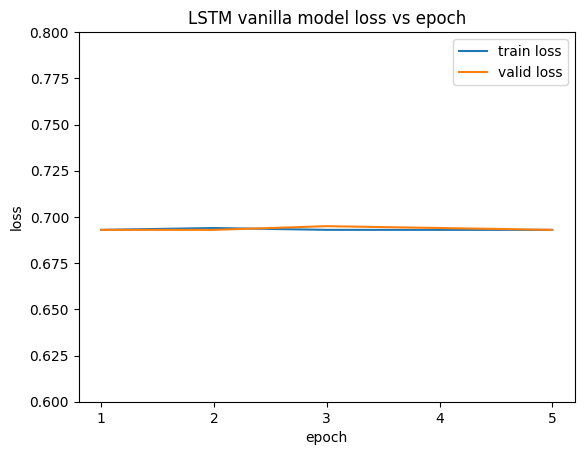

In [41]:
epoch = [i for i in range(1, 6)]
train_loss = [0.693, 0.694, 0.693, 0.693, 0.693]
valid_loss = [0.693, 0.693, 0.695, 0.694, 0.693]

plt.plot(epoch, train_loss, label='train loss')
plt.plot(epoch, valid_loss, label='valid loss')
plt.legend()
plt.xticks(epoch)
plt.ylim(0.6, 0.8)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('LSTM vanilla model loss vs epoch')
plt.show()

### Lag 1 (h) Train GRU with vanilla hyperparameters.

In [42]:
org_hyperparams = HyperParams()
_ = train_and_test_model_with_hparams(org_hyperparams, "gru_1layer_base_sgd_e32_h100", override_models_with_gru=True)

shape of train data is (35000,)
shape of validation data is (5000,)
shape of test data is (10000,)
Length of vocabulary is 37996
The model has 69,098 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 26.49it/s]
epoch: 1
train_loss: 0.694, train_acc: 0.499
valid_loss: 0.693, valid_acc: 0.489
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 26.53it/s]
epoch: 2
train_loss: 0.693, train_acc: 0.500
valid_loss: 0.699, valid_acc: 0.489
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 26.29it/s]
epoch: 3
train_loss: 0.694, train_acc: 0.502
valid_loss: 0.693, valid_acc: 0.511
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 26.44it/s]
epoch: 4
train_loss: 0.694, train_acc: 0.500
valid_loss: 0.695, valid_acc: 0.489
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 26.23it/s]
epoch: 5
train_loss: 0.694, train_acc: 0.501
valid_loss: 0.693, valid_acc: 0.511
evaluating...: 100%|██████████| 105/105 [00:04<00:00, 26.01it/s]
test_loss: 0.693, test_acc: 0.504


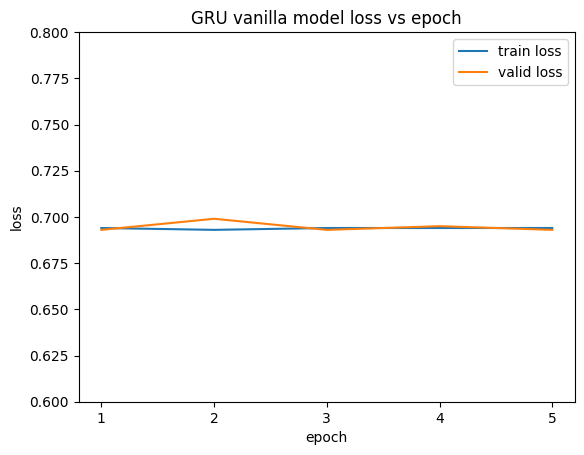

In [43]:
epoch = [i for i in range(1, 6)]
train_loss = [0.694, 0.693, 0.694, 0.694, 0.694]
valid_loss = [0.693, 0.699, 0.693, 0.695, 0.693]

plt.plot(epoch, train_loss, label='train loss')
plt.plot(epoch, valid_loss, label='valid loss')
plt.legend()
plt.xticks(epoch)
plt.ylim(0.6, 0.8)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('GRU vanilla model loss vs epoch')
plt.show()

# Lab 2

### Lab 2 (a) Study of LSTM Optimizers. Hint: For adaptive optimizers, we recommend using a learning rate of 0.001 (instead of 0.01).

In [84]:
sdg_hyperparams = HyperParams()

adagrad_hyperparams = HyperParams()   
adagrad_hyperparams.OPTIM = "adagrad"
adagrad_hyperparams.LR = 0.001

rmsprop_hyperparams = HyperParams()
rmsprop_hyperparams.OPTIM = "rmsprop"
rmsprop_hyperparams.LR = 0.001

adam_hyperparams = HyperParams()
adam_hyperparams.OPTIM = "adam"
adam_hyperparams.LR = 0.001

In [89]:
l_test_loss = []
l_test_acc = []
for hyperparams in [sdg_hyperparams, adagrad_hyperparams, rmsprop_hyperparams, adam_hyperparams]:
    print(f"Training with hyperparams: {hyperparams.OPTIM}")
    result = train_and_test_model_with_hparams(hyperparams, f"lstm_{hyperparams.OPTIM}")
    l_test_loss.append(result["test_loss"])
    l_test_acc.append(result["test_acc"])
    print("=====================================")

Training with hyperparams: sgd
shape of train data is (35000,)
shape of validation data is (5000,)
shape of test data is (10000,)
Length of vocabulary is 37996
The model has 79,398 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 25.63it/s]
epoch: 1
train_loss: 0.693, train_acc: 0.503
valid_loss: 0.693, valid_acc: 0.511
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 26.00it/s]
epoch: 2
train_loss: 0.694, train_acc: 0.503
valid_loss: 0.693, valid_acc: 0.511
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 24.92it/s]
epoch: 3
train_loss: 0.693, train_acc: 0.502
valid_loss: 0.695, valid_acc: 0.489
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 25.76it/s]
epoch: 4
train_loss: 0.693, train_acc: 0.503
valid_loss: 0.694, valid_acc: 0.489
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 25.80it/s]
epoch: 5
train_loss: 0.693, train_acc: 0.503
valid_loss: 0.693, valid_acc: 0.511
evaluating...: 100%|██████████| 105/105 [00:04<00:00, 24.22it/s]
test_loss: 0.

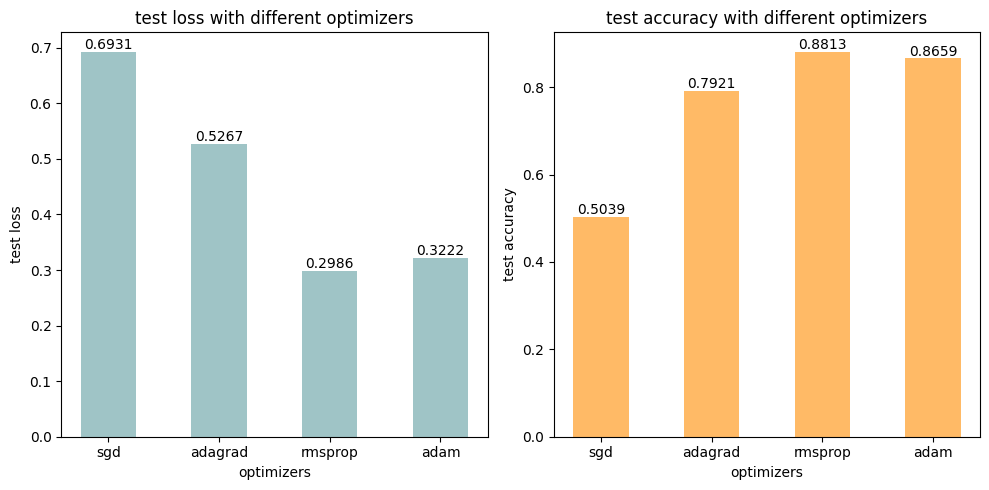

In [110]:
# plot the loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(['sgd', 'adagrad', 'rmsprop', 'adam'], l_test_loss, width=0.5, color='cadetblue', alpha=0.6)
plt.xlabel('optimizers')
plt.ylabel('test loss')
for i in range(len(l_test_loss)):
    plt.text(i, l_test_loss[i]+0.005, round(l_test_loss[i], 4), ha='center')
plt.title('test loss with different optimizers')

plt.subplot(1, 2, 2)
plt.bar(['sgd', 'adagrad', 'rmsprop', 'adam'], l_test_acc, width=0.5, color='darkorange', alpha=0.6)
plt.xlabel('optimizers')
plt.ylabel('test accuracy')
for i in range(len(l_test_acc)):
    plt.text(i, l_test_acc[i]+0.005, round(l_test_acc[i], 4), ha='center')
plt.title('test accuracy with different optimizers')

plt.tight_layout()
plt.show()

### Lab 2 (b): Study of GRU Optimizers. Hint: For adaptive optimizers, we recommend using a learning rate of 0.001 (instead of 0.01).

In [111]:
l_test_loss = []
l_test_acc = []
for hyperparams in [sdg_hyperparams, adagrad_hyperparams, rmsprop_hyperparams, adam_hyperparams]:
    print(f"Training with hyperparams: {hyperparams.OPTIM}")
    result = train_and_test_model_with_hparams(hyperparams, f"gru_{hyperparams.OPTIM}", override_models_with_gru=True)
    l_test_loss.append(result["test_loss"])
    l_test_acc.append(result["test_acc"])
    print("=====================================")

Training with hyperparams: sgd
shape of train data is (35000,)
shape of validation data is (5000,)
shape of test data is (10000,)
Length of vocabulary is 37996
The model has 69,098 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 26.55it/s]
epoch: 1
train_loss: 0.694, train_acc: 0.499
valid_loss: 0.693, valid_acc: 0.489
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 25.46it/s]
epoch: 2
train_loss: 0.693, train_acc: 0.500
valid_loss: 0.699, valid_acc: 0.489
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 25.66it/s]
epoch: 3
train_loss: 0.694, train_acc: 0.502
valid_loss: 0.693, valid_acc: 0.511
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 24.41it/s]
epoch: 4
train_loss: 0.694, train_acc: 0.500
valid_loss: 0.695, valid_acc: 0.489
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 26.80it/s]
epoch: 5
train_loss: 0.694, train_acc: 0.501
valid_loss: 0.693, valid_acc: 0.511
evaluating...: 100%|██████████| 105/105 [00:03<00:00, 26.52it/s]
test_loss: 0.

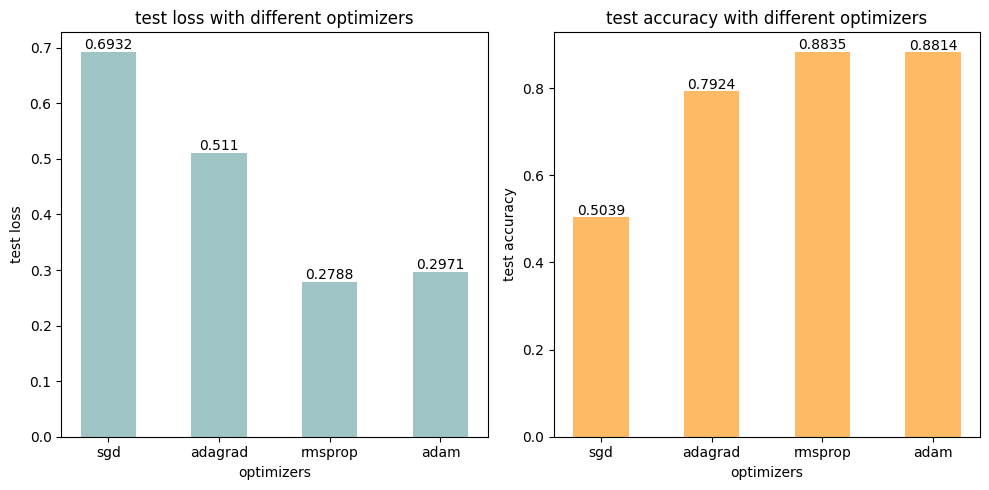

In [112]:
# plot the loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(['sgd', 'adagrad', 'rmsprop', 'adam'], l_test_loss, width=0.5, color='cadetblue', alpha=0.6)
plt.xlabel('optimizers')
plt.ylabel('test loss')
for i in range(len(l_test_loss)):
    plt.text(i, l_test_loss[i]+0.005, round(l_test_loss[i], 4), ha='center')
plt.title('test loss with different optimizers')

plt.subplot(1, 2, 2)
plt.bar(['sgd', 'adagrad', 'rmsprop', 'adam'], l_test_acc, width=0.5, color='darkorange', alpha=0.6)
plt.xlabel('optimizers')
plt.ylabel('test accuracy')
for i in range(len(l_test_acc)):
    plt.text(i, l_test_acc[i]+0.005, round(l_test_acc[i], 4), ha='center')
plt.title('test accuracy with different optimizers')

plt.tight_layout()
plt.show()

### Lab 2 (c) Deeper LSTMs

In [17]:
layer_1 = HyperParams()
layer_1.OPTIM = "rmsprop"
layer_1.LR = 0.001
layer_1.N_LAYERS = 1

layer_2 = HyperParams()
layer_2.OPTIM = "rmsprop"
layer_2.LR = 0.001
layer_2.N_LAYERS = 2

layer_3 = HyperParams()
layer_3.OPTIM = "rmsprop"
layer_3.LR = 0.001
layer_3.N_LAYERS = 3

In [18]:
l_test_loss = []
l_test_acc = []

for hyperparams in [layer_1, layer_2, layer_3]:
    print(f"Training with hyperparams: {hyperparams.N_LAYERS}")
    result = train_and_test_model_with_hparams(hyperparams, f"lstm_{hyperparams.N_LAYERS}layer")
    l_test_loss.append(result["test_loss"])
    l_test_acc.append(result["test_acc"])
    print("=====================================")

Training with hyperparams: 1
shape of train data is (35000,)
shape of validation data is (5000,)
shape of test data is (10000,)
Length of vocabulary is 37996
The model has 79,398 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 25.80it/s]
epoch: 1
train_loss: 0.665, train_acc: 0.592
valid_loss: 0.500, valid_acc: 0.773
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 25.86it/s]
epoch: 2
train_loss: 0.522, train_acc: 0.748
valid_loss: 0.462, valid_acc: 0.798
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 25.46it/s]
epoch: 3
train_loss: 0.419, train_acc: 0.810
valid_loss: 0.380, valid_acc: 0.832
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 25.60it/s]
epoch: 4
train_loss: 0.242, train_acc: 0.905
valid_loss: 0.295, valid_acc: 0.882
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 25.35it/s]
epoch: 5
train_loss: 0.171, train_acc: 0.938
valid_loss: 0.352, valid_acc: 0.859
evaluating...: 100%|██████████| 105/105 [00:04<00:00, 24.97it/s]
test_loss: 0.29

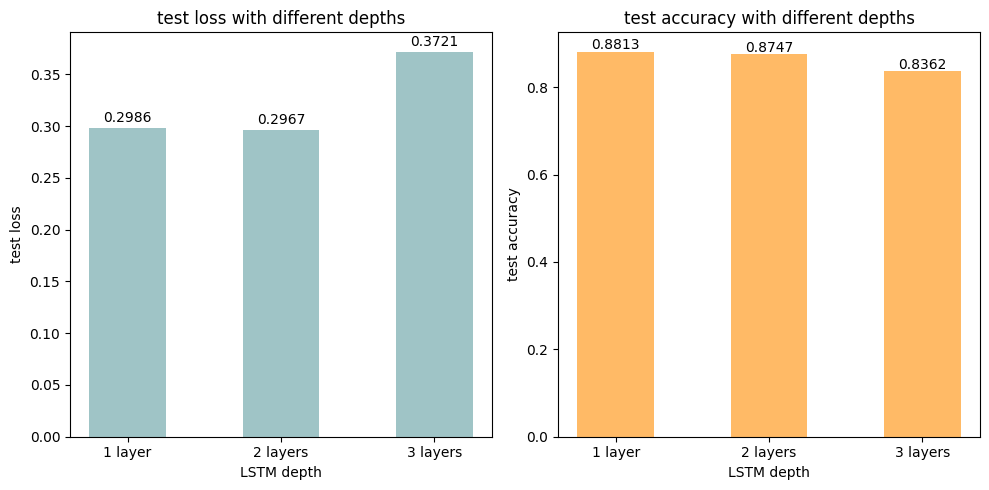

In [19]:
# plot the loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(['1 layer', '2 layers', '3 layers'], l_test_loss, width=0.5, color='cadetblue', alpha=0.6)
plt.xlabel('LSTM depth')
plt.ylabel('test loss')
for i in range(len(l_test_loss)):
    plt.text(i, l_test_loss[i]+0.005, round(l_test_loss[i], 4), ha='center')
plt.title('test loss with different depths')

plt.subplot(1, 2, 2)
plt.bar(['1 layer', '2 layers', '3 layers'], l_test_acc, width=0.5, color='darkorange', alpha=0.6)
plt.xlabel('LSTM depth')
plt.ylabel('test accuracy')
for i in range(len(l_test_acc)):
    plt.text(i, l_test_acc[i]+0.005, round(l_test_acc[i], 4), ha='center')
plt.title('test accuracy with different depths')

plt.tight_layout()
plt.show()

### Lab 2 (d) Wider LSTMs

In [21]:
h_100 = HyperParams()
h_100.OPTIM = "rmsprop"
h_100.LR = 0.001
h_100.HIDDEN_DIM = 100

h_200 = HyperParams()
h_200.OPTIM = "rmsprop"
h_200.LR = 0.001
h_200.HIDDEN_DIM = 200

h_300 = HyperParams()
h_300.OPTIM = "rmsprop"
h_300.LR = 0.001
h_300.HIDDEN_DIM = 300

In [22]:
l_test_loss = []
l_test_acc = []

for hyperparams in [h_100, h_200, h_300]:
    print(f"Training with hyperparams: {hyperparams.HIDDEN_DIM}")
    result = train_and_test_model_with_hparams(hyperparams, f"lstm_h{hyperparams.HIDDEN_DIM}")
    l_test_loss.append(result["test_loss"])
    l_test_acc.append(result["test_acc"])
    print("=====================================")

Training with hyperparams: 100
shape of train data is (35000,)
shape of validation data is (5000,)
shape of test data is (10000,)
Length of vocabulary is 37996
The model has 79,398 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 25.10it/s]
epoch: 1
train_loss: 0.665, train_acc: 0.592
valid_loss: 0.500, valid_acc: 0.773
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 25.13it/s]
epoch: 2
train_loss: 0.522, train_acc: 0.748
valid_loss: 0.462, valid_acc: 0.798
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 25.14it/s]
epoch: 3
train_loss: 0.419, train_acc: 0.810
valid_loss: 0.380, valid_acc: 0.832
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 24.81it/s]
epoch: 4
train_loss: 0.242, train_acc: 0.905
valid_loss: 0.295, valid_acc: 0.882
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 25.11it/s]
epoch: 5
train_loss: 0.171, train_acc: 0.938
valid_loss: 0.352, valid_acc: 0.859
evaluating...: 100%|██████████| 105/105 [00:04<00:00, 25.31it/s]
test_loss: 0.

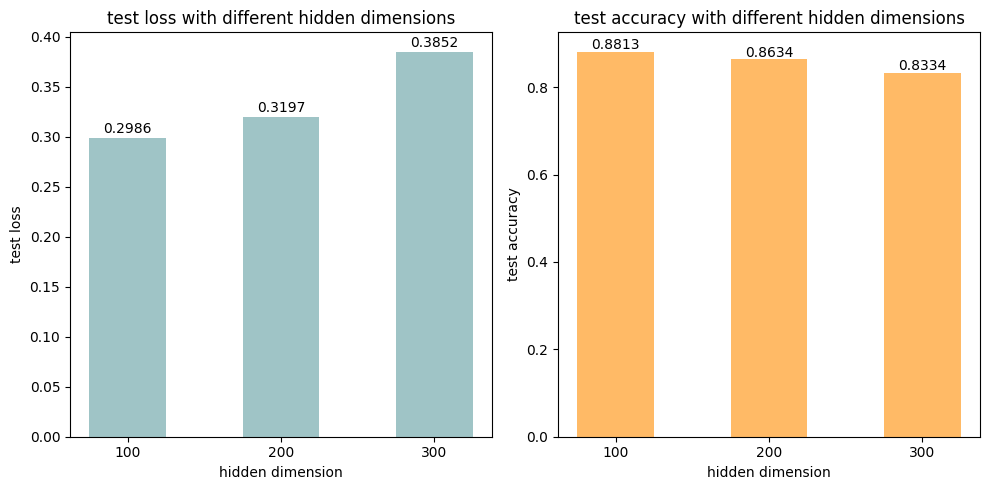

In [23]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(['100', '200', '300'], l_test_loss, width=0.5, color='cadetblue', alpha=0.6)
plt.xlabel('hidden dimension')
plt.ylabel('test loss')
for i in range(len(l_test_loss)):
    plt.text(i, l_test_loss[i]+0.005, round(l_test_loss[i], 4), ha='center')
plt.title('test loss with different hidden dimensions')

plt.subplot(1, 2, 2)
plt.bar(['100', '200', '300'], l_test_acc, width=0.5, color='darkorange', alpha=0.6)
plt.xlabel('hidden dimension')
plt.ylabel('test accuracy')
for i in range(len(l_test_acc)):
    plt.text(i, l_test_acc[i]+0.005, round(l_test_acc[i], 4), ha='center')
plt.title('test accuracy with different hidden dimensions')
plt.tight_layout()
plt.show()

### Lab 2 (e) Larger Embedding Table

In [27]:
embedding_1 = HyperParams()
embedding_1.OPTIM = "rmsprop"
embedding_1.LR = 0.001
embedding_1.EMBEDDING_DIM = 1

embedding_32 = HyperParams()
embedding_32.OPTIM = "rmsprop"
embedding_32.LR = 0.001
embedding_32.EMBEDDING_DIM = 32

embedding_64 = HyperParams()
embedding_64.OPTIM = "rmsprop"
embedding_64.LR = 0.001
embedding_64.EMBEDDING_DIM = 64

embedding_128 = HyperParams()
embedding_128.OPTIM = "rmsprop"
embedding_128.LR = 0.001
embedding_128.EMBEDDING_DIM = 128

embedding_256 = HyperParams()
embedding_256.OPTIM = "rmsprop"
embedding_256.LR = 0.001
embedding_256.EMBEDDING_DIM = 256

In [28]:
l_test_loss = []
l_test_acc = []

for hyperparams in [embedding_1, embedding_32, embedding_64, embedding_128, embedding_256]:
    print(f"Training with hyperparams: {hyperparams.EMBEDDING_DIM}")
    result = train_and_test_model_with_hparams(hyperparams, f"lstm_e{hyperparams.EMBEDDING_DIM}")
    l_test_loss.append(result["test_loss"])
    l_test_acc.append(result["test_acc"])
    print("=====================================")

Training with hyperparams: 1
shape of train data is (35000,)
shape of validation data is (5000,)
shape of test data is (10000,)
Length of vocabulary is 37996
The model has 79,398 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 26.41it/s]
epoch: 1
train_loss: 0.665, train_acc: 0.592
valid_loss: 0.500, valid_acc: 0.773
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 26.37it/s]
epoch: 2
train_loss: 0.522, train_acc: 0.748
valid_loss: 0.462, valid_acc: 0.798
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 23.00it/s]
epoch: 3
train_loss: 0.419, train_acc: 0.810
valid_loss: 0.380, valid_acc: 0.832
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 25.89it/s]
epoch: 4
train_loss: 0.242, train_acc: 0.905
valid_loss: 0.295, valid_acc: 0.882
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 25.15it/s]
epoch: 5
train_loss: 0.171, train_acc: 0.938
valid_loss: 0.352, valid_acc: 0.859
evaluating...: 100%|██████████| 105/105 [00:04<00:00, 25.85it/s]
test_loss: 0.29

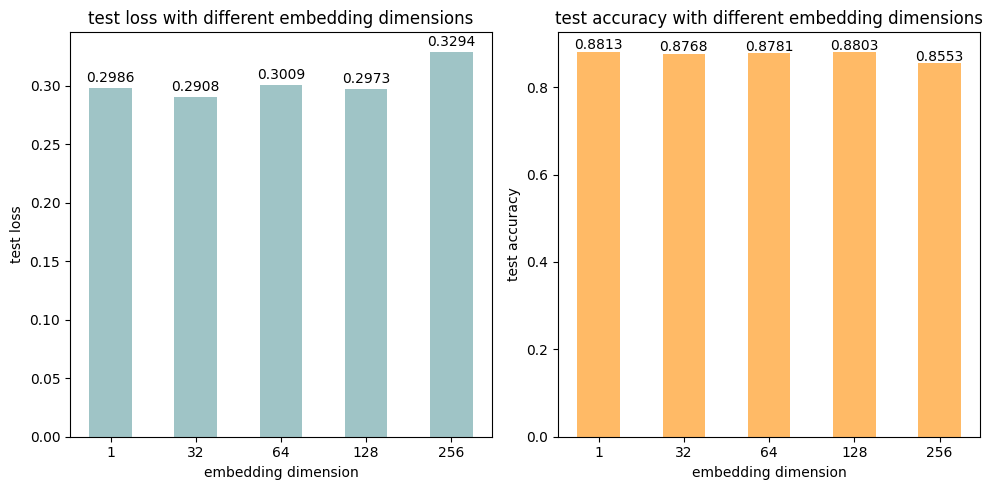

In [29]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(['1', '32', '64', '128', '256'], l_test_loss, width=0.5, color='cadetblue', alpha=0.6)
plt.xlabel('embedding dimension')
plt.ylabel('test loss')
for i in range(len(l_test_loss)):
    plt.text(i, l_test_loss[i]+0.005, round(l_test_loss[i], 4), ha='center')
plt.title('test loss with different embedding dimensions')

plt.subplot(1, 2, 2)
plt.bar(['1', '32', '64', '128', '256'], l_test_acc, width=0.5, color='darkorange', alpha=0.6)
plt.xlabel('embedding dimension')
plt.ylabel('test accuracy')
for i in range(len(l_test_acc)):
    plt.text(i, l_test_acc[i]+0.005, round(l_test_acc[i], 4), ha='center')
plt.title('test accuracy with different embedding dimensions')
plt.tight_layout()
plt.show()

### Lab 2(f) Compound scaling of embedding_dim, hidden_dim, layers

In [30]:
n_layers = [1, 2, 3]
hidden_dims = [100, 200, 300]
embedding_dims = [32, 64, 128]

l_hyperparams = []
l_test_num_params = []
l_test_acc = []

for n_layer in n_layers:
    for hidden_dim in hidden_dims:
        for embedding_dim in embedding_dims:
            hyperparams = HyperParams()
            hyperparams.OPTIM = "rmsprop"
            hyperparams.LR = 0.001
            hyperparams.N_LAYERS = n_layer
            hyperparams.HIDDEN_DIM = hidden_dim
            hyperparams.EMBEDDING_DIM = embedding_dim
            result = train_and_test_model_with_hparams(hyperparams, f"lstm_{n_layer}layer_h{hidden_dim}_e{embedding_dim}")
            l_hyperparams.append(f"{n_layer}layer_h{hidden_dim}_e{embedding_dim}")
            l_test_num_params.append(result["num_params"])
            l_test_acc.append(result["test_acc"])
            print("=====================================")

shape of train data is (35000,)
shape of validation data is (5000,)
shape of test data is (10000,)
Length of vocabulary is 37996
The model has 1,269,674 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 25.92it/s]
epoch: 1
train_loss: 0.670, train_acc: 0.620
valid_loss: 0.535, valid_acc: 0.737
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 26.21it/s]
epoch: 2
train_loss: 0.319, train_acc: 0.866
valid_loss: 0.287, valid_acc: 0.880
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 25.90it/s]
epoch: 3
train_loss: 0.162, train_acc: 0.941
valid_loss: 0.352, valid_acc: 0.874
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 26.18it/s]
epoch: 4
train_loss: 0.076, train_acc: 0.974
valid_loss: 0.395, valid_acc: 0.869
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 26.16it/s]
epoch: 5
train_loss: 0.035, train_acc: 0.989
valid_loss: 0.537, valid_acc: 0.867
evaluating...: 100%|██████████| 105/105 [00:04<00:00, 25.91it/s]
test_loss: 0.291, test_acc: 0.877
shape o

In [33]:
# save the results
df = pd.DataFrame({'hyperparams': l_hyperparams, 'test_num_params': l_test_num_params, 'test_acc': l_test_acc})
df.to_csv('lstm_compoud_scaling.csv', index=False)

In [30]:
df = pd.read_csv('lstm_compoud_scaling.csv')
l_hyperparams = df['hyperparams'].tolist()
l_test_num_params = df['test_num_params'].tolist()
l_test_acc = df['test_acc'].tolist()

# sort by test accuracy
df.sort_values(by=['test_acc'], inplace=False, ascending=False)

,hyperparams,test_num_params,test_acc
9,2layer_h100_e32,1350474,0.880556
2,1layer_h100_e128,4955690,0.880258
16,2layer_h300_e64,3593946,0.878571
1,1layer_h100_e64,2498346,0.878075
13,2layer_h200_e64,2966546,0.877183
10,2layer_h100_e64,2579146,0.876885
0,1layer_h100_e32,1269674,0.876786
5,1layer_h200_e128,5127890,0.876687
18,3layer_h100_e32,1431274,0.876687
21,3layer_h200_e32,2046674,0.876488


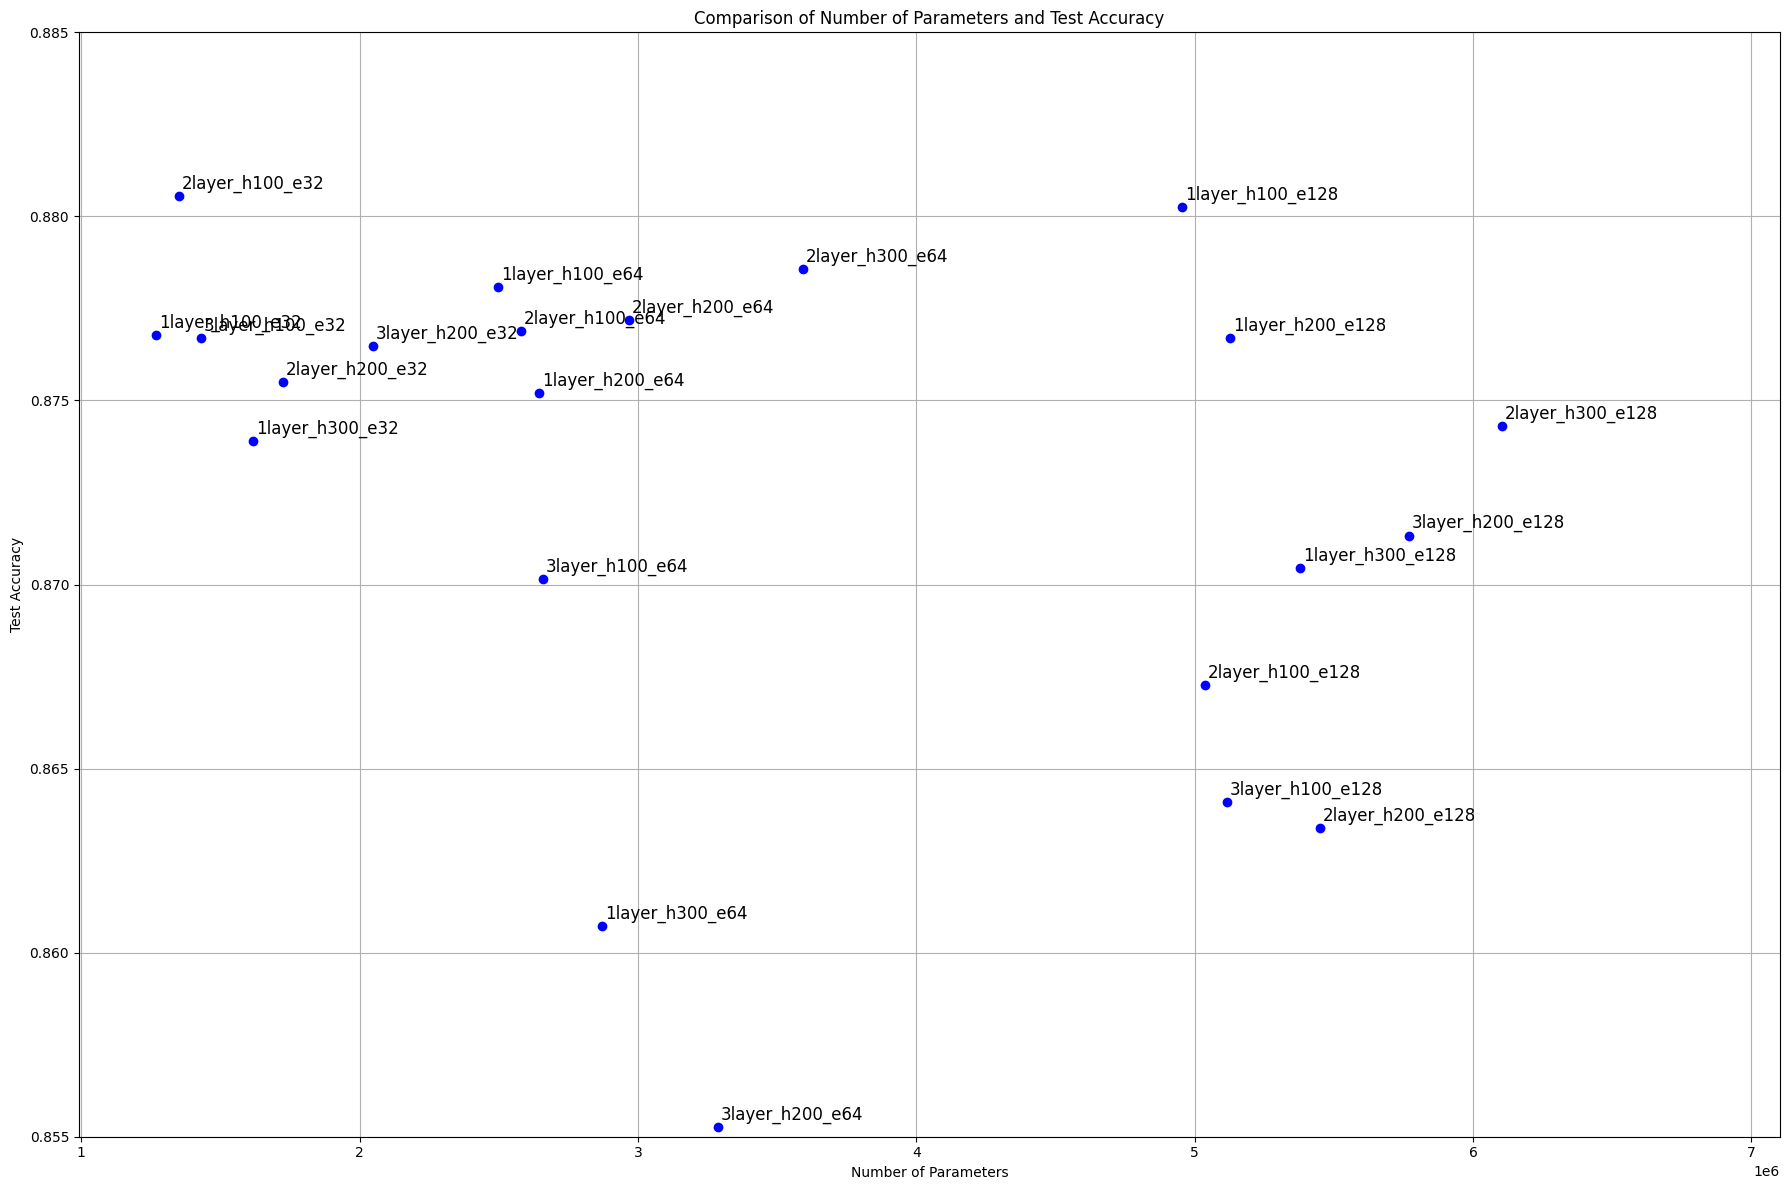

In [47]:
# Create a scatter plot
plt.figure(figsize=(18, 12))
plt.scatter(l_test_num_params, l_test_acc, color='blue', marker='o')

# Annotate each point with the hyperparameter setting
for i, txt in enumerate(l_hyperparams):
    plt.annotate(txt, (l_test_num_params[i]+10000, l_test_acc[i]+0.0002), fontsize=12)
plt.ylim(0.855, 0.885)
# Set the title and labels
plt.title("Comparison of Number of Parameters and Test Accuracy")
plt.xlabel("Number of Parameters")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

### Lab 2 (g) Bi-Directional LSTM, using best architecture from (f)

best architecture from (f) is 2 layer, 100 hidden dimensions and 32 embeddings.

In [44]:
layer2_h100_e32 = HyperParams()
layer2_h100_e32.OPTIM = "rmsprop"
layer2_h100_e32.LR = 0.001
layer2_h100_e32.N_LAYERS = 2
layer2_h100_e32.HIDDEN_DIM = 100
layer2_h100_e32.EMBEDDING_DIM = 32
layer2_h100_e32.BIDIRECTIONAL = True

In [46]:
bi_results = train_and_test_model_with_hparams(layer2_h100_e32, f"lstm_{layer2_h100_e32.N_LAYERS}layer_h{layer2_h100_e32.HIDDEN_DIM}_e{layer2_h100_e32.EMBEDDING_DIM}")

shape of train data is (35000,)
shape of validation data is (5000,)
shape of test data is (10000,)
Length of vocabulary is 37996
The model has 1,564,874 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 20.77it/s]
epoch: 1
train_loss: 0.652, train_acc: 0.627
valid_loss: 0.620, valid_acc: 0.637
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 20.94it/s]
epoch: 2
train_loss: 0.400, train_acc: 0.823
valid_loss: 0.300, valid_acc: 0.877
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 20.94it/s]
epoch: 3
train_loss: 0.219, train_acc: 0.919
valid_loss: 0.332, valid_acc: 0.874
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 20.91it/s]
epoch: 4
train_loss: 0.132, train_acc: 0.955
valid_loss: 0.352, valid_acc: 0.866
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 20.89it/s]
epoch: 5
train_loss: 0.080, train_acc: 0.974
valid_loss: 0.436, valid_acc: 0.863
evaluating...: 100%|██████████| 105/105 [00:05<00:00, 20.43it/s]
test_loss: 0.308, test_acc: 0.877
